In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from datasets.cifar10_dataset import Cifar10Dataset

In [2]:
trainset = Cifar10Dataset(is_train=True)
testset = Cifar10Dataset(is_train=False)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=4)

In [3]:
import matplotlib.pyplot as plt
import einops

In [4]:
trainiter = iter(trainloader)

def show_batch(batch):
    images, labels = batch['image'], batch['label']
    images = einops.rearrange(trainset.inv_transform(images), 'b c h w -> b h w c')

    plt.figure(figsize=(12, 12))
    for i in range(len(images)):
        plt.subplot(4, len(images)//4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f'{labels[i].item()}: {trainset.classes[labels[i].item()]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

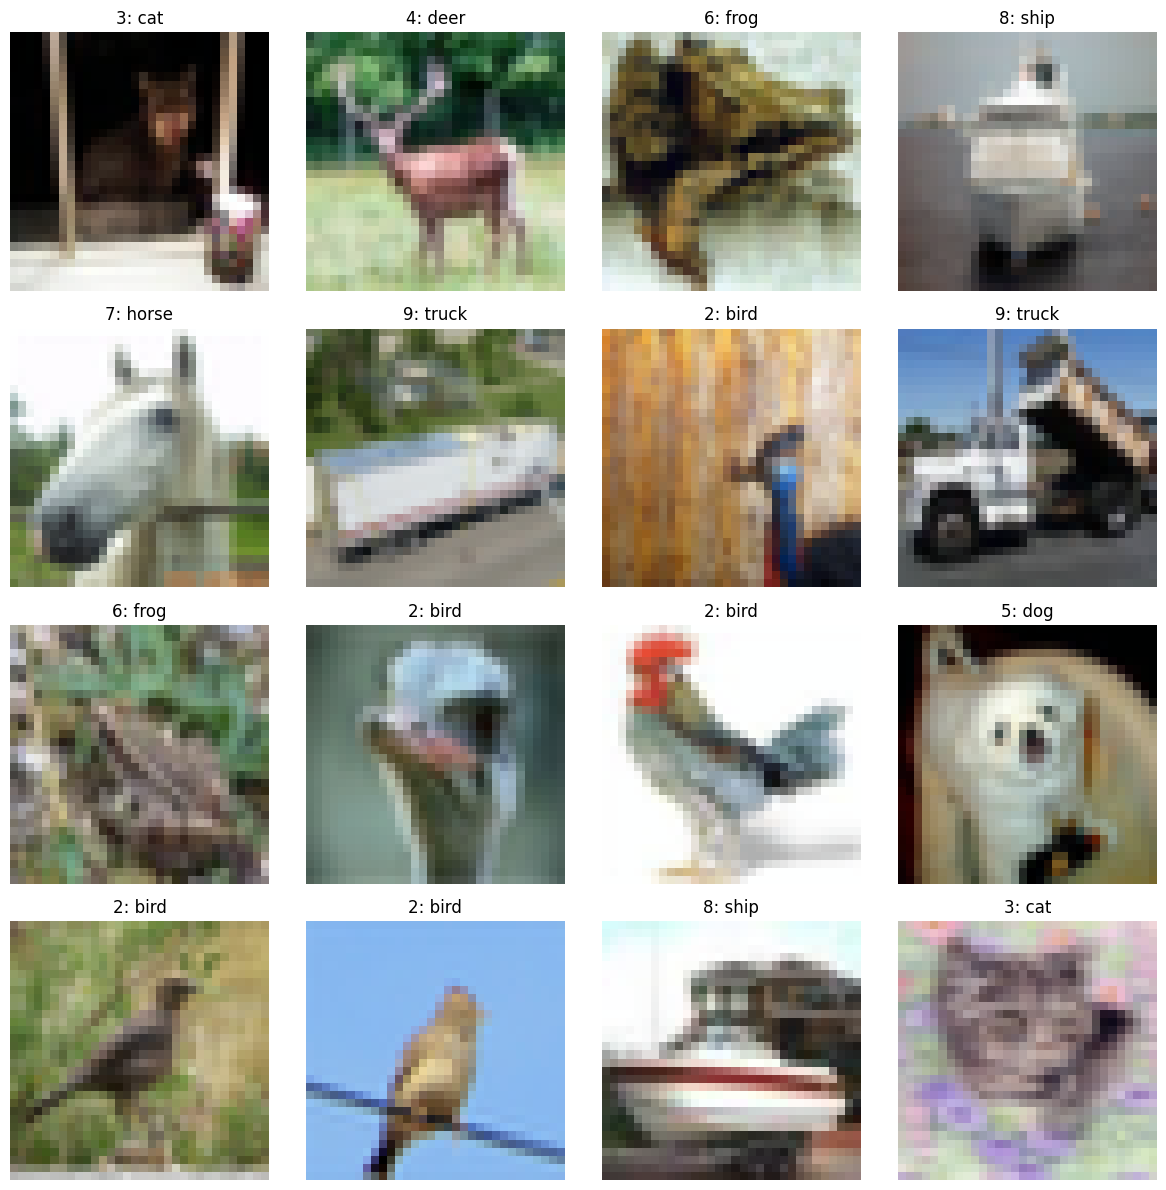

In [5]:
show_batch(next(trainiter))

In [6]:
import models

In [7]:
device = torch.device('mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='mps')

In [8]:
net = models.CNN(input_nc = 3, num_classes = 10, net_name=None, use_dropout=False, pool_type='max').to(device)
net

CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Identity()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Identity()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (output_activation): LogSoftmax(dim=1)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'].to(device), data['label'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    # Evaluate on test set at the end of each epoch
    net.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for test_data in testloader:
            test_images, test_labels = test_data['image'].to(device), test_data['label'].to(device)
            test_outputs = net(test_images)
            test_loss += criterion(test_outputs, test_labels).item()
            _, predicted = torch.max(test_outputs, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum().item()
    
    test_accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    print(f'Epoch {epoch + 1} validation - Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.2f}%')
    net.train()

print('Finished Training')

Epoch 1, Batch 500, Loss: 4.089
Epoch 1, Batch 1000, Loss: 4.113
Epoch 1, Batch 1500, Loss: 4.144
Epoch 1, Batch 2000, Loss: 3.966
Epoch 1, Batch 2500, Loss: 4.034
Epoch 1, Batch 3000, Loss: 3.933
Epoch 1 validation - Loss: 0.872, Accuracy: 69.54%
Epoch 2, Batch 500, Loss: 3.667
Epoch 2, Batch 1000, Loss: 3.636
Epoch 2, Batch 1500, Loss: 3.550
Epoch 2, Batch 2000, Loss: 3.588
Epoch 2, Batch 2500, Loss: 3.569
Epoch 2, Batch 3000, Loss: 3.490
Epoch 2 validation - Loss: 0.822, Accuracy: 71.23%
Epoch 3, Batch 500, Loss: 3.181
Epoch 3, Batch 1000, Loss: 3.229
Epoch 3, Batch 1500, Loss: 3.192
Epoch 3, Batch 2000, Loss: 3.195
Epoch 3, Batch 2500, Loss: 3.192
Epoch 3, Batch 3000, Loss: 3.194
Epoch 3 validation - Loss: 0.850, Accuracy: 70.73%
Epoch 4, Batch 500, Loss: 2.771
Epoch 4, Batch 1000, Loss: 2.774
Epoch 4, Batch 1500, Loss: 2.779
Epoch 4, Batch 2000, Loss: 2.773
Epoch 4, Batch 2500, Loss: 2.833
Epoch 4, Batch 3000, Loss: 2.900
Epoch 4 validation - Loss: 0.823, Accuracy: 72.49%
Epoch 5,